In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_C
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 6
Title         = 'Heart Disease'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Class_data = BB_Model(dataset = 'Heart')
                      
#Class_data.df().head()

In [6]:
Class_data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.819672131147541


MLPClassifier(random_state=RandomState(MT19937) at 0x1BF14189840)

In [7]:
Class_data.Random_Forest()

0.8360655737704918


RandomForestClassifier(random_state=RandomState(MT19937) at 0x1BF14189840)

In [8]:
#Class_data.GP()

In [9]:
Class_data.L_Regression()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.819672131147541


LogisticRegression()

In [10]:
print(Class_data.get_features())

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Class_data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Class_data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Class_data.get_features(),
                   categorical_features = Class_data.get_catagorical(),
                   mode                 = Class_data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Class_data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Class_data.get_features(),
                     categorical_features = Class_data.get_catagorical(),
                     mode                 = Class_data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [5.48842975e+01 6.85950413e-01 2.14049587e+00 1.31256198e+02
 2.47351240e+02 1.65289256e-01 1.03305785e+00 1.49615702e+02
 3.30578512e-01 1.05000000e+00 5.90909091e-01 7.27272727e-01
 1.82231405e+00]
Std 0:  [ 8.97488699  0.46413623  0.97324358 17.53086012 48.94089641  0.37144141
  0.99531036 22.4967638   0.47042147  1.15484069  0.62489669  0.97064348
  0.95640404]


In [14]:
# Generate explantion data for Random Forest

Class_Stats   = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = ['Not-Diabetic', 'Diabetic'],
                                     X_train_std   = Class_data.get_X_train_std(),
                                     N_consistancy = N_consistancy)

Class_Stats_2 = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = ['Not-Diabetic', 'Diabetic'],
                                     X_train_std   = Class_data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern_3",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Class_data.get_Random_Forest().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

#    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Class_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern_3",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Class_data.get_L_Regression().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Class_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.41 0.59]] [1.00000000e+00 9.99999486e-06]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.29755283 0.70244717]] [1.00000000e+00 1.00000004e-05]
INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and cal

ADD ----> [[0.01 0.99]] [1.00000000e+00 1.00000004e-05]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.0051012 0.9948988]] [1.00000000e+00 2.18221897e-06]
INSTANCE:  2
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.63 0.37]] [-1.34883600e-08  9.99559741e-06]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.46197271 0.53802729]] [1.00000002e+00 9.99998376e-06]
INSTANCE:  3
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.88 0.12]] [-7.31636973e-14  9.99998931e-06]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.9114675 0.0885325]] [-4.31323643e-10  9.99998931e-06]
INSTANCE:  4
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 7 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.61 0.39]] [-4.19947973e-12  9.99608611e-06]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.79501647 0.20498353]] [-2.41896689e-08  9.99786301e-06]
INSTANCE:  5
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.05 0.95]] [1.00000000e+00 9.99881796e-06]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

ADD ----> [[0.05663317 0.94336683]] [1.000000e+00 9.999956e-06]


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[[0.05663317 0.94336683]]
[1.000000e+00 9.999956e-06]


In [17]:
Class_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


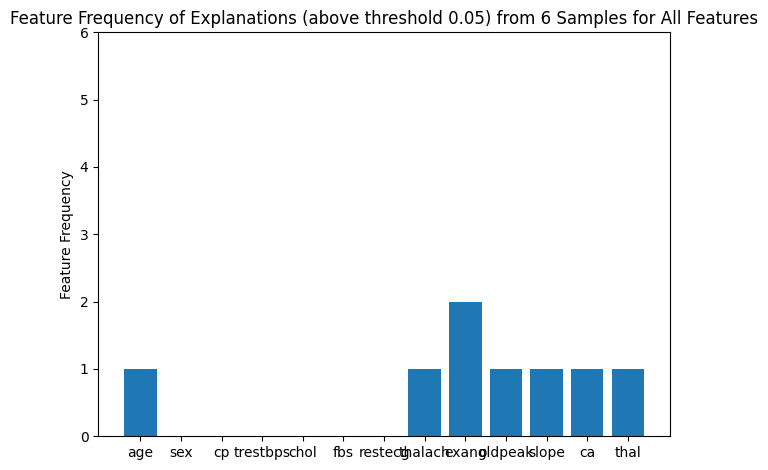

In [18]:
Class_Stats.Frequency_Plot()


In [19]:
Class_Stats.Class_Fidelity()

F and E Predictions All [[0.41 0.59]
 [0.01 0.99]
 [0.63 0.37]
 [0.88 0.12]
 [0.61 0.39]
 [0.05 0.95]] [[ 1.00000000e+00  9.99999486e-06]
 [ 1.00000000e+00  1.00000004e-05]
 [-1.34883600e-08  9.99559741e-06]
 [-7.31636973e-14  9.99998931e-06]
 [-4.19947973e-12  9.99608611e-06]
 [ 1.00000000e+00  9.99881796e-06]]
F and E Predictions [0.59 0.99 0.37 0.12 0.39 0.95] [9.99999486e-06 1.00000004e-05 9.99559741e-06 9.99998931e-06
 9.99608611e-06 9.99881796e-06]
F and E Outcomes [1 1 0 0 0 1] [0 0 1 1 1 0]
BB(x) - exp(x) proba dif  Avg:  0.6716616685847171  var:  0.07454825513288497  max:  0.989999999996291
Scores:
BB Model Score:   0.5
Exp Model Score:  0.5
BB - Exp Score:   0.0
Fidelity:  0.3283
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0


In [20]:
Class_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.2394179894179894
Mean Jaccard Distance:    0.7605820105820106


top_features True
top_features (6, 13)


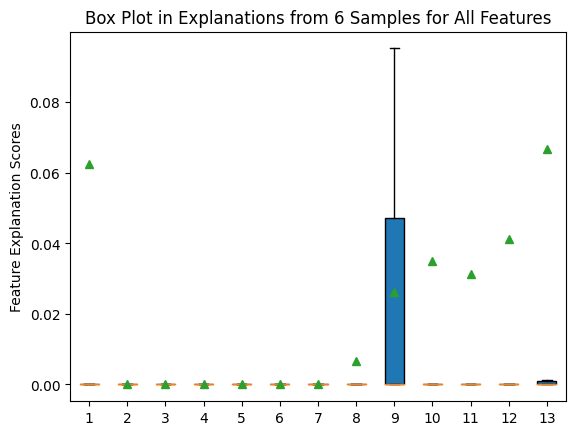

1 -      age
2 -      sex
3 -      cp
4 -      trestbps
5 -      chol
6 -      fbs
7 -      restecg
8 -      thalach
9 -      exang
10 -     oldpeak
11 -     slope
12 -     ca
13 -     thal


In [21]:
Class_Stats.Box_Plot()


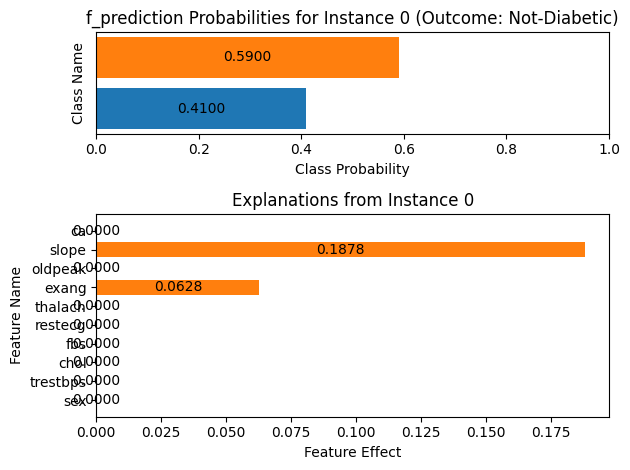

In [22]:
Class_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[ 6.37360591e-20 -1.60768293e-21  9.28234411e-20 -9.81182104e-22
 -2.41947603e-22  2.16717282e-20 -6.54375709e-22 -6.39014858e-22
  9.52380938e-02  3.03977210e-22  5.37231395e-22 -2.82835795e-22
 -6.55563381e-24]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.18704035e-04 1.02500461e-04 1.42969032e-02 5.43418775e-07
 6.29532997e-07 2.36467585e-02 5.77472330e-07 5.90126889e-07
 2.61104202e+00 5.09804577e-07 5.17006421e-07 5.03219006e-07
 5.03219006e-07]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[7.93016458e-17 2.29258240e-25 7.40161562e-17 1.37456184e-16
 1.26882631e-16 1.21599099e-16 1.00448750e-16 1.21595855e-16
 2.02787093e-01 7.93016446e-17 8.45884209e-17 1.00448750e-16
 1.00448750e-16]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.54831672e-10 4.07052252e-12 8.75447412e-11 6.81514195e-13
 5.96656396e-15 0.00000000e+00 0.00000000e+00 6.76210582e-13
 1.30000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warn

[1.98282790e+00 8.56950784e-03 1.22540303e-01 1.07531864e+00
 2.38765725e+00 4.85049096e-03 9.74892740e-03 6.65969795e-02
 6.97914751e+00 3.34978017e-04 9.84427086e-03 5.07656030e-02
 3.01797646e-01]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-2.62343704e+05 -1.62855221e+03  2.21925288e+07 -2.91281915e+04
 -1.72711915e+02 -1.11368389e+07  8.58743009e+02  5.74178141e+04
 -2.76753665e+03  4.21047390e+02  1.60024254e+03 -2.01717166e+07
  3.86771061e+06]


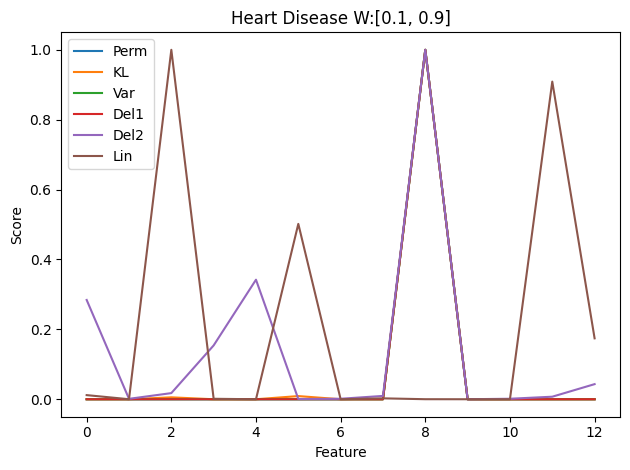

In [29]:
URM_Exp.plot_scores(Title)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.12295682e-01  7.01879521e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.52526207e-01  2.26804916e-01  2.03109222e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

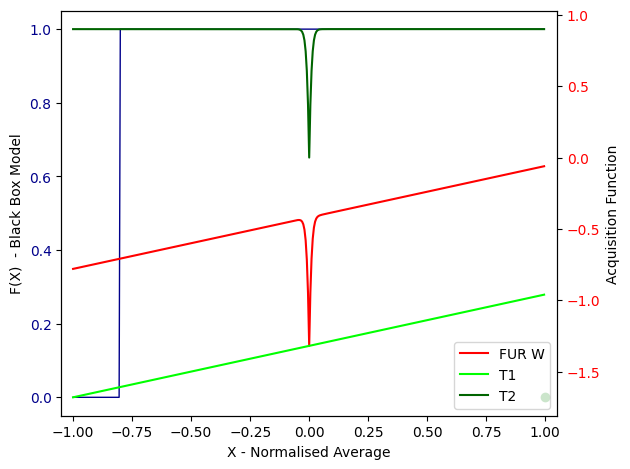

In [32]:
acq_data.plot_point(0)

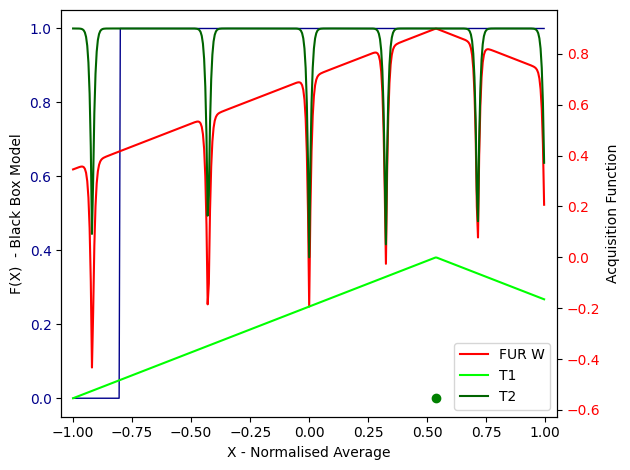

In [33]:
acq_data.plot_point(5)

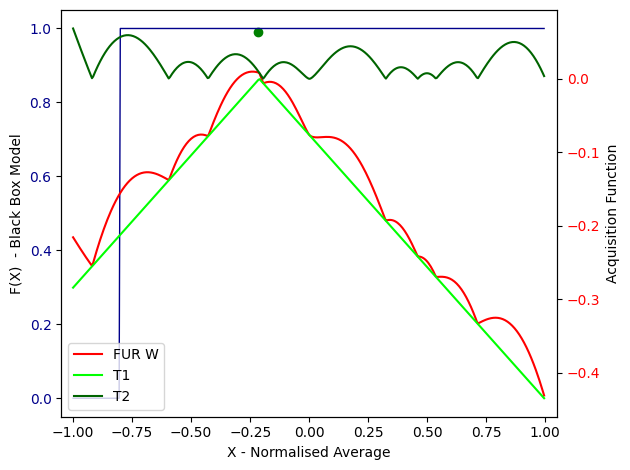

In [34]:
acq_data.plot_point(10)

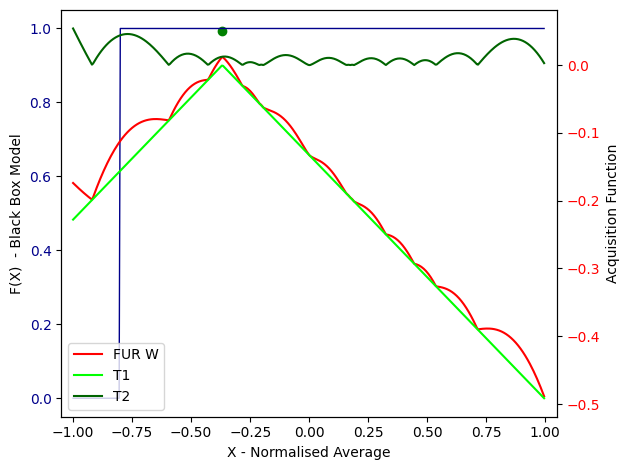

In [35]:
acq_data.plot_point(15)

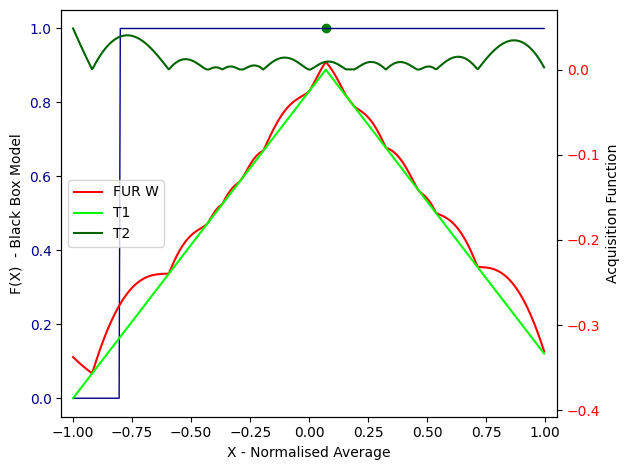

In [36]:
acq_data.plot_point(19)

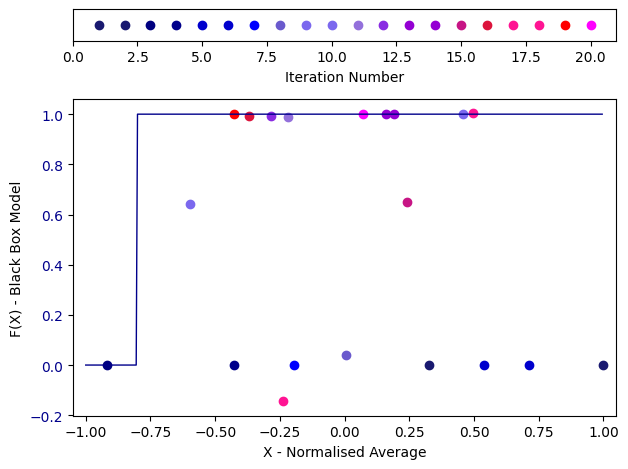

In [37]:
acq_data.plot_all()

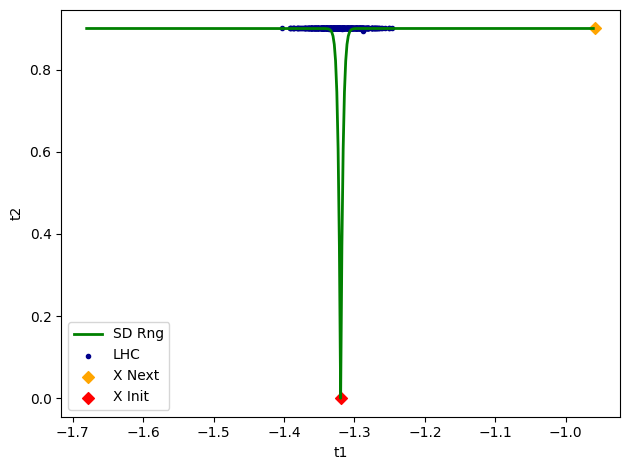

In [38]:
acq_data.plot_t1_t2(0)

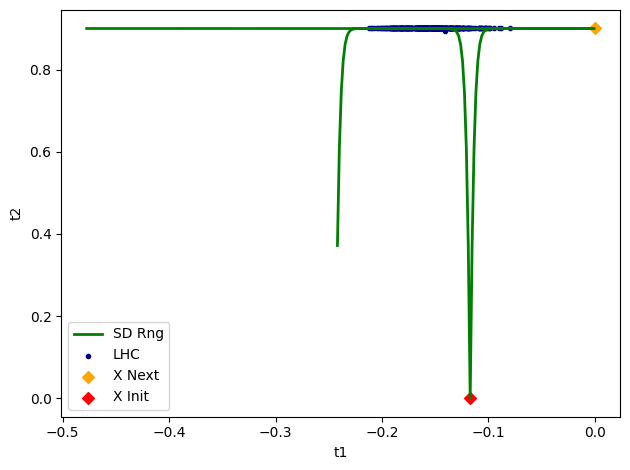

In [39]:
acq_data.plot_t1_t2(1)

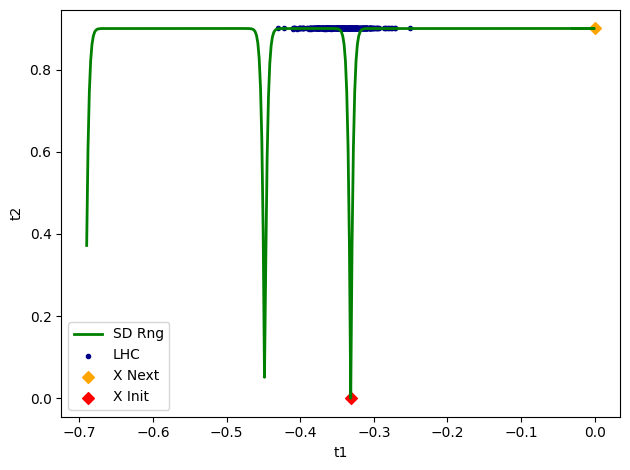

In [40]:
acq_data.plot_t1_t2(2)

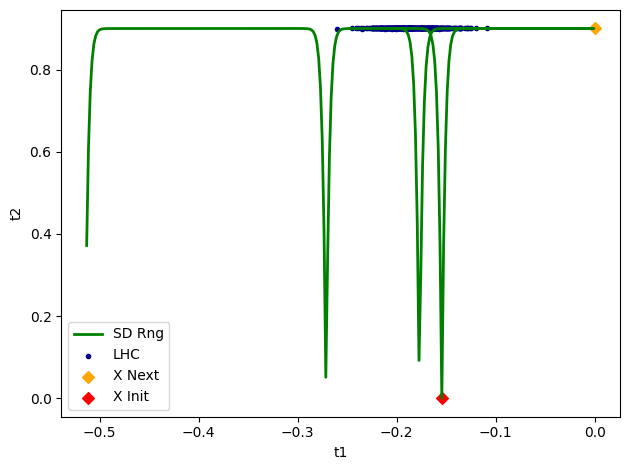

In [41]:
acq_data.plot_t1_t2(3)

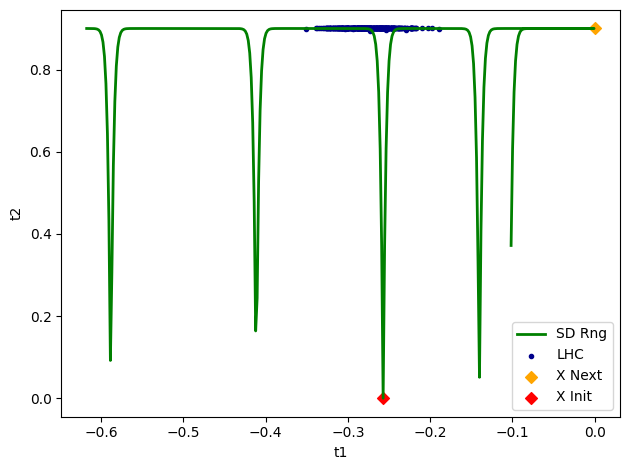

In [42]:
acq_data.plot_t1_t2(4)

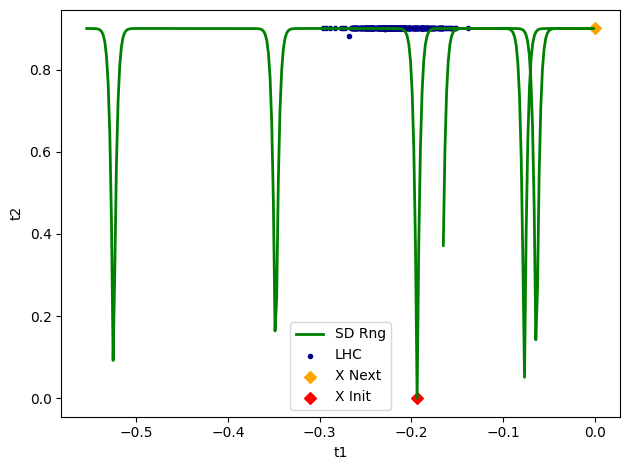

In [43]:
acq_data.plot_t1_t2(5)

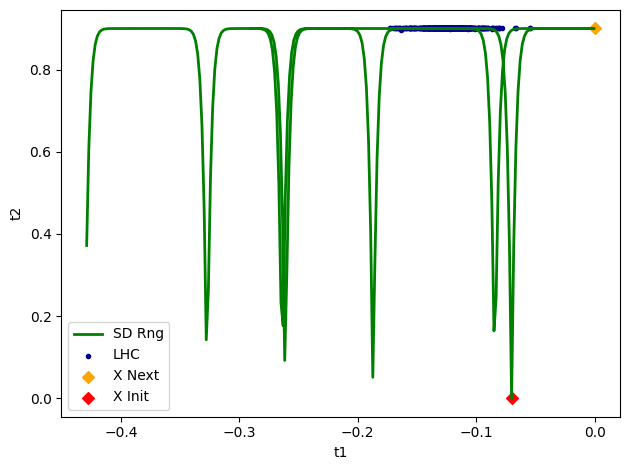

In [44]:
acq_data.plot_t1_t2(6)

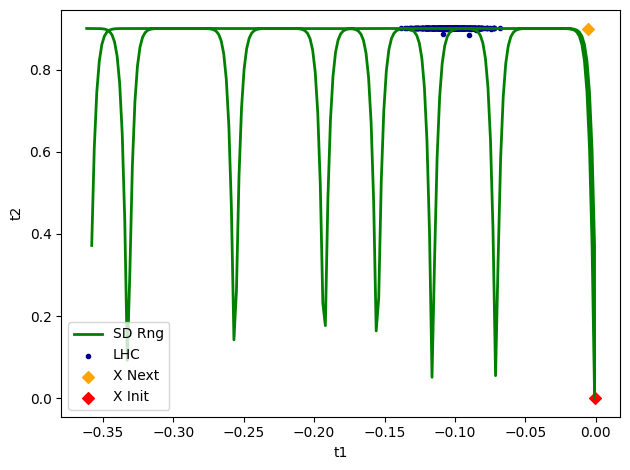

In [45]:
acq_data.plot_t1_t2(7)

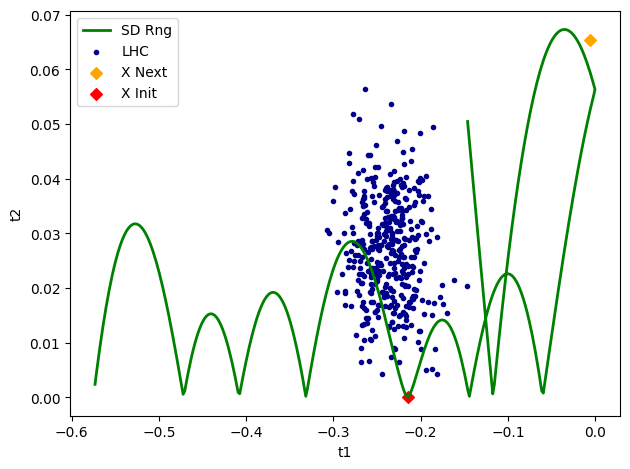

In [46]:
acq_data.plot_t1_t2(8)

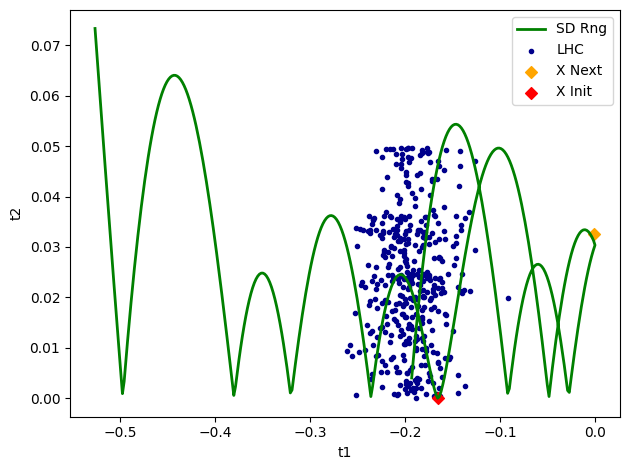

In [47]:
acq_data.plot_t1_t2(9)

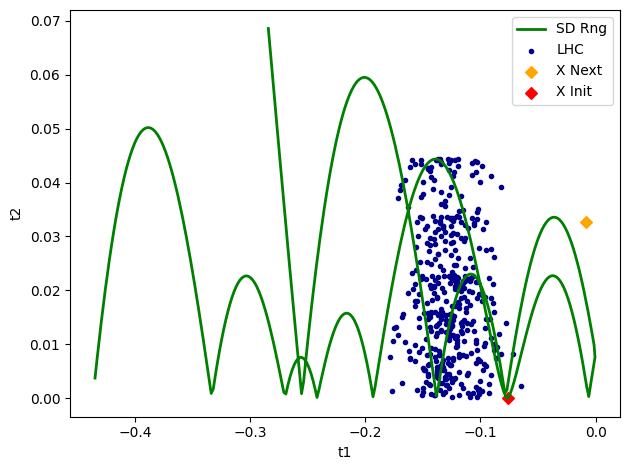

In [48]:
acq_data.plot_t1_t2(10)

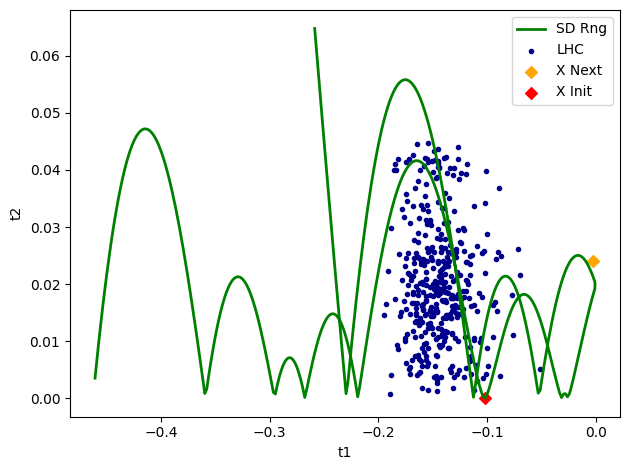

In [49]:
acq_data.plot_t1_t2(11)

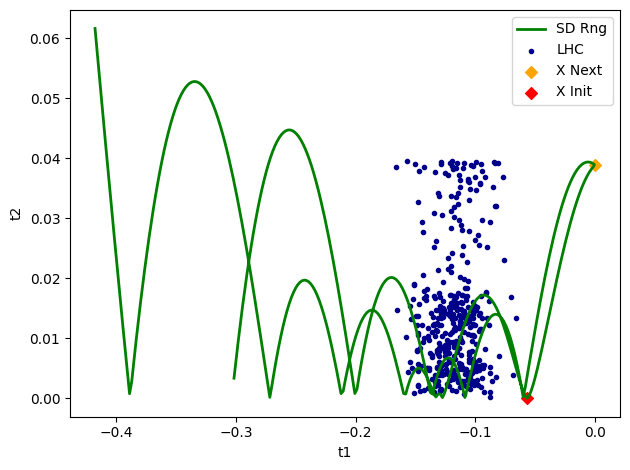

In [50]:
acq_data.plot_t1_t2(12)

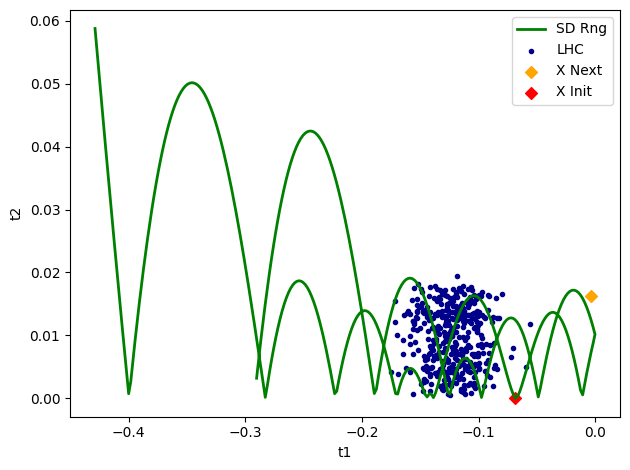

In [51]:
acq_data.plot_t1_t2(13)

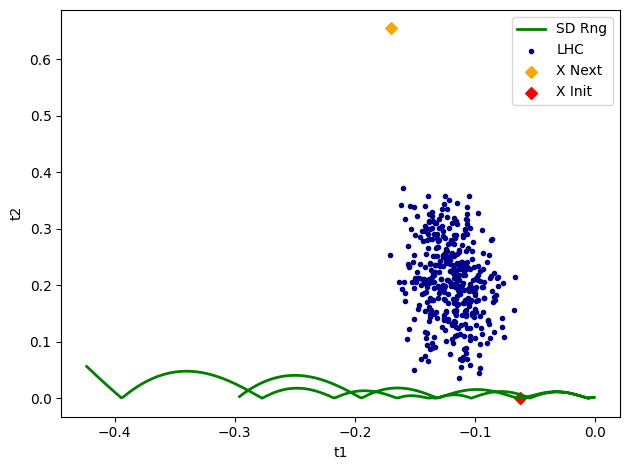

In [52]:
acq_data.plot_t1_t2(14)

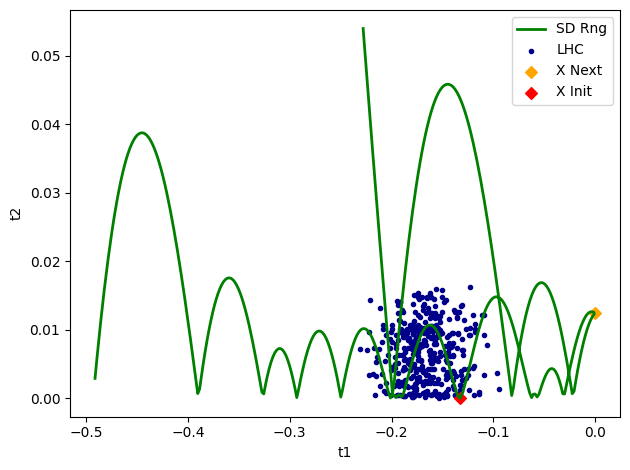

In [53]:
acq_data.plot_t1_t2(15)

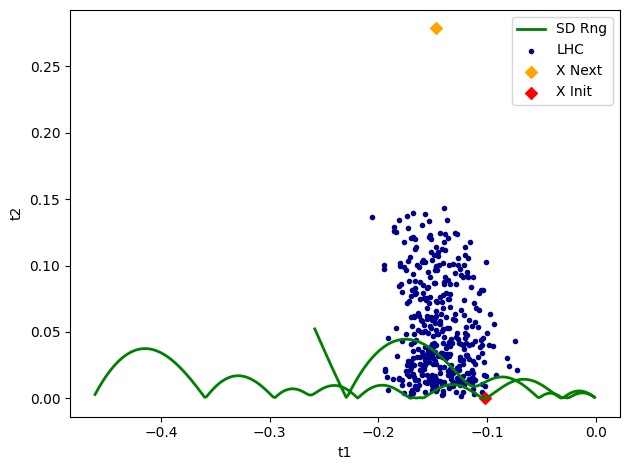

In [54]:
acq_data.plot_t1_t2(16)

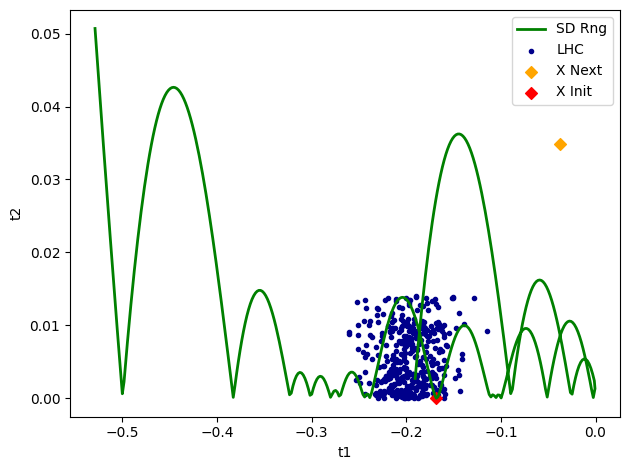

In [55]:
acq_data.plot_t1_t2(17)

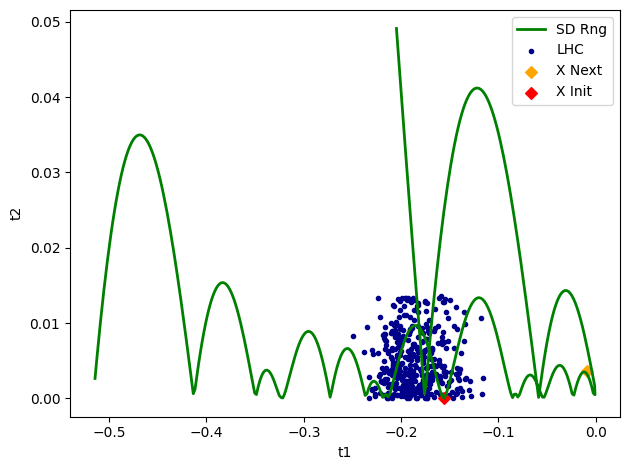

In [56]:
acq_data.plot_t1_t2(18)

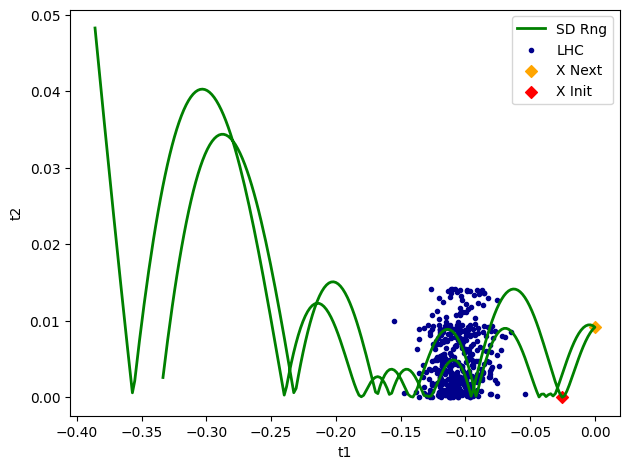

In [57]:
acq_data.plot_t1_t2(19)

In [58]:
Class_Stats.Class_Fidelity()

print('Fidelity: ', Class_Stats.fidelity)

F and E Predictions All [[0.41 0.59]
 [0.01 0.99]
 [0.63 0.37]
 [0.88 0.12]
 [0.61 0.39]
 [0.05 0.95]] [[ 1.00000000e+00  9.99999486e-06]
 [ 1.00000000e+00  1.00000004e-05]
 [-1.34883600e-08  9.99559741e-06]
 [-7.31636973e-14  9.99998931e-06]
 [-4.19947973e-12  9.99608611e-06]
 [ 1.00000000e+00  9.99881796e-06]]
F and E Predictions [0.59 0.99 0.37 0.12 0.39 0.95] [9.99999486e-06 1.00000004e-05 9.99559741e-06 9.99998931e-06
 9.99608611e-06 9.99881796e-06]
F and E Outcomes [1 1 0 0 0 1] [0 0 1 1 1 0]
BB(x) - exp(x) proba dif  Avg:  0.6716616685847171  var:  0.07454825513288497  max:  0.989999999996291
Scores:
BB Model Score:   0.5
Exp Model Score:  0.5
BB - Exp Score:   0.0
Fidelity:  0.3283
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0
Fidelity:  0.3283383314152829


In [59]:
Class_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Class_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.16507936507936505
Mean Jaccard Distance:    0.834920634920635
Jaccard:  0.16507936507936505


In [60]:
Class_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

Consistancey Std/P Pert:  0.3 : 0.0006835672263066425
Perturbed Changes: 0.0 0.0 0.0 0.0


In [61]:
Class_Stats.Compare_Models (model_b = Class_Stats_2)

mean_scores:  [6.24204198e-02 7.71035195e-19 1.10440774e-20 3.89701610e-20
 2.72294398e-21 9.07931559e-19 2.53453473e-20 6.67548263e-03
 2.63366084e-02 3.49206331e-02 3.13083133e-02 4.12698412e-02
 6.68843303e-02]
mean_scores_d:  [6.57998708e-02 3.52611785e-02 2.66731235e-15 2.14133472e-18
 9.90566365e-20 1.17519326e-02 1.92776236e-02 3.00697745e-02
 7.77044593e-03 3.34230999e-18 2.31095757e-02 2.09378666e-02
 1.85825290e-02]
Score Diff Mean:  [-0.0263566  -1.         -0.99999172 -0.96425256 -0.94649331 -1.
 -1.         -0.63666154  0.54434963  1.          0.15066254  0.32684012
  0.56515241]
Score Diff SD:    [0.73996047 1.41443089 2.23602285 2.20441015 2.1147717  2.23606798
 2.23606798 1.95209524 1.37088815 2.23606798 1.72205936 1.79266531
 1.90130374]
 Model Feature Correlation:  0.450782238522558


In [62]:
Class_Stats.Calibration()

Brier_Score:  0.4999900004955575


In [63]:
Class_Stats.delete_one()

mean_variance [1.93647136e-08 2.75083104e-11 2.55608497e-12 1.38221147e-10
 7.54602862e-12 0.00000000e+00 3.87871772e-11 3.66456843e-02
 4.25808633e-01 1.56807561e-01 1.42759894e-01 6.65802228e-09
 1.18628647e-03]
Mean scores: [6.24204198e-02 7.71035195e-19 1.10440774e-20 3.89701610e-20
 2.72294398e-21 9.07931559e-19 2.53453473e-20 6.67548263e-03
 2.63366084e-02 3.49206331e-02 3.13083133e-02 4.12698412e-02
 6.68843303e-02]
sort_order [ 4  2  6  3  1  5  7  8 10  9 11  0 12]
norm sorted_scores [1.31194297e-19 5.32115233e-19 1.22116542e-18 1.87762323e-18
 3.71492844e-17 4.37450948e-17 3.21631755e-01 1.26892542e+00
 1.50846737e+00 1.68251273e+00 1.98842424e+00 3.00748130e+00
 3.22255719e+00]
norm sorted_variance [1.28534241e-10 4.35387220e-11 6.60676051e-10 2.35437092e-09
 4.68559025e-10 0.00000000e+00 6.24199226e-01 7.25295281e+00
 2.43168103e+00 2.67096004e+00 1.13408507e-07 3.29846188e-07
 2.02064475e-02]
Prediction Variance Feature Deletion 1: [1.93647136e-08 2.75083104e-11 2.55608497

In [64]:
Class_Stats.Results_Summary(Title)

Results_Summary: Heart Disease W:[0.1, 0.9]
Timestamp:  2023-05-13 10:28:24.318242
 Model Feature Correlation:  0.450782238522558
Fidelity:                 0.3283
Accuracy Score:           0.0
Balanced Accuracy Score:  0.0
Consistancey Std/P Pert:  0.3 : 0.0006835672263066425
Delete 1 error:       1.261270128645762
Delete 1 Correlation: 0.15331628158435348
Mean Jaccard Similarity:  0.16507936507936505
Mean Jaccard Distance:    0.834920634920635
Brier_Score:  0.4999900004955575
